### **1. Setup and Imports**

### Import necessary libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

### **2. Load the Dataset**

### Activate pandas2ri for R to pandas conversion

In [29]:
pandas2ri.activate()

### Load AdhereR's med.events dataset

In [30]:
robjects.r('library(AdhereR)')
med_events_r = robjects.r('med.events')
med_events = pandas2ri.rpy2py(med_events_r)

### Create a copy for manipulation

In [31]:
ExamplePats = med_events.copy()
tidy = ExamplePats.copy()
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format='%m/%d/%Y')

### **3. Define the `See()` Function**

In [32]:
def See(arg1):
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()
    
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p1 = C09CA01.copy()
    
    Drug_see_p1 = Drug_see_p1.sort_values(by=['pnr', 'eksd'])
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])
    
    Drug_see_p1 = Drug_see_p1.groupby('pnr', group_keys=False).apply(lambda x: x.sample(n=1, random_state=1234))
    Drug_see_p1 = Drug_see_p1[['pnr', 'eksd', 'prev_eksd']].copy()
    Drug_see_p1['event.interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days.astype(float)
    
    ecdf_func = ECDF(Drug_see_p1['event.interval'])
    x_vals, y_vals = ecdf_func.x, ecdf_func.y
    dfper = pd.DataFrame({'x': x_vals, 'y': y_vals})
    
    dfper = dfper[dfper['y'] <= 0.8]
    dfper = dfper[np.isfinite(dfper['x'])]
    max_x = dfper['x'].max()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(dfper['x'], dfper['y'])
    axs[0].set_title("80% ECDF")
    axs[1].plot(x_vals, y_vals)
    axs[1].set_title("100% ECDF")
    plt.show()
    
    m1 = Drug_see_p1['pnr'].value_counts()
    m1.plot(kind='bar', title="Frequency of pnr")
    plt.show()
    
    log_event = np.log(Drug_see_p1['event.interval'].astype(float))
    density = gaussian_kde(log_event)
    x1 = np.linspace(log_event.min(), log_event.max(), 100)
    y1 = density(x1)
    
    plt.plot(x1, y1)
    plt.title("Log(event interval)")
    plt.show()
    
    a_df = pd.DataFrame({'x': x1, 'y': y1})
    scaler = StandardScaler()
    a_scaled = scaler.fit_transform(a_df)
    a_scaled = pd.DataFrame(a_scaled, columns=['x', 'y'])
    
    best_k, best_score = None, -1
    scores = {}
    
    for k in range(2, 10):
        km = KMeans(n_clusters=k, random_state=1234, n_init=10)
        km.fit(a_scaled)
        score = silhouette_score(a_scaled, km.labels_)
        scores[k] = score
        if score > best_score:
            best_score = score
            best_k = k
    
    plt.plot(list(scores.keys()), list(scores.values()), marker='o')
    plt.title("Silhouette Analysis")
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette score")
    plt.show()
    
    km_final = KMeans(n_clusters=best_k, random_state=1234, n_init=10)
    km_final.fit(dfper[['x']])
    dfper['cluster'] = km_final.labels_
    
    return dfper

### **4. Define the `see_assumption()` Function**

In [33]:
def see_assumption(arg1):
    arg1 = arg1.sort_values(by=['pnr', 'eksd'])
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)
    arg1['p_number'] = arg1.groupby('pnr').cumcount() + 1
    
    Drug_see2 = arg1[arg1['p_number'] >= 2].copy()
    Drug_see2 = Drug_see2[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    Drug_see2['Duration'] = (Drug_see2['eksd'] - Drug_see2['prev_eksd']).dt.days.astype(float)
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='p_number', y='Duration', data=Drug_see2)
    plt.title("Boxplot of Duration by p_number")
    plt.show()
    
    return plt

### Preparing the Data:
**pnr**: Patient Number <br>
**eksd**: A date string (prescription date) <br>
**perday**: Some daily measure <br>
**ATC**: A drug code <br>
**dur_original**: The original duration <br>

### Setting a Parameter
**arg1** is used to filter the data. In this case, only rows where ATC column equals to **medA** will be processed.

### Defining the Function
This function processes the data using The Sessa Empirical Estimator which uses K-means clustering. There are a few disadvantages to this which is why there will be a comparisson with another clustering method.

This function accepts one parameter (drug code which in this case is medA). <br>
It filters the tidy DataFrame where ATC equals to the argument passed which is copied into **C09CA01** <br>
<br>
We create 2 copies **Drug_see_p0** for merging results and **Drug_see_p1** for processing. Then, we sort and compute the previous dates.

We then do random sampling of patients (grouped by pnr). This also retains only **pnr**, **eksd** and **prev_eksd** columns. <br>
It also computes for the time difference in days between the **eksd** and **prev_eksd**

We now create the ECDF, which is from the statsmodels, to calculate the empirical cumulative distribution of **event_interval**. <br>

This filters the rows where the cumulative probability is less than or equal to 80%. We also remove infinities to ensure that only finite **x** values remain which prevents errors.

This creates a figure with 2 side-by-side plots. <br>
**Left Plot**: plots the filtered ECDF (80% of the data) <br>
**Right Plot**: Plots the complete ECDF (100%) <br>
**Frequency Count**: Counts how many times each patient appears. <br>
**Bar Plot**: Plots the frequency counts as a bar chart. <br><br>
Then we filter based on maximum ECDF Value.

This takes the natural logarithm of the **event_interval** and uses the **gaussian_kde** to estimate the density of the log-transformed data which can be used to create 100 evenly spaced values between the minimum and maximum of the log-transformed data.

We now iterate though possible numbers of clusters (loop over k) and sets the optimal number of clusters based on the highest silhouette score.

We are now summarizing clusters. For each cluster, **ni2** computes for the minimum of the log-transformed x values while **ni3** is for the maximum. We are also combining the 2 DataFrames sibe by side.

Cross Join by creating a temporary column key with a constant value in both DataFrames, then we remove it after merging.

We do some checks here to check if the merged DataFrame has a column named **Cluster_y**. if not, it renames it automatically.

This creates a frequency table for **Cluster** in the results DataFrame. This determines the cluster that appears most frequently. It merges this information back to **results** and then into **Drug_see_p1**, then fills missing values in the **Median** and **Cluster**.<br><br>
It then computes a new column **test** as the difference between **event.interval** and **Median**, then merges **Drug_see_p0** and **Drug_see_p1** so that final durations and clusters are assigned. This makes it so that **Drug_see_p0** will contain and be returned with the processed data with assigned durations and clusters.

### Visualize the Duration
This creates boxplots for us to visualize the duration by event number (difference between prescription).

It sorts the data by **pnr** and **eksd** and computes the previous date for each patient. It then assigns event numbers and filters over it which keeps one event where **p_number** is 2 or higher since the first event has no previous event.

### Generating Data and Running the Functions
Lastly, we run the functions to see the plots.

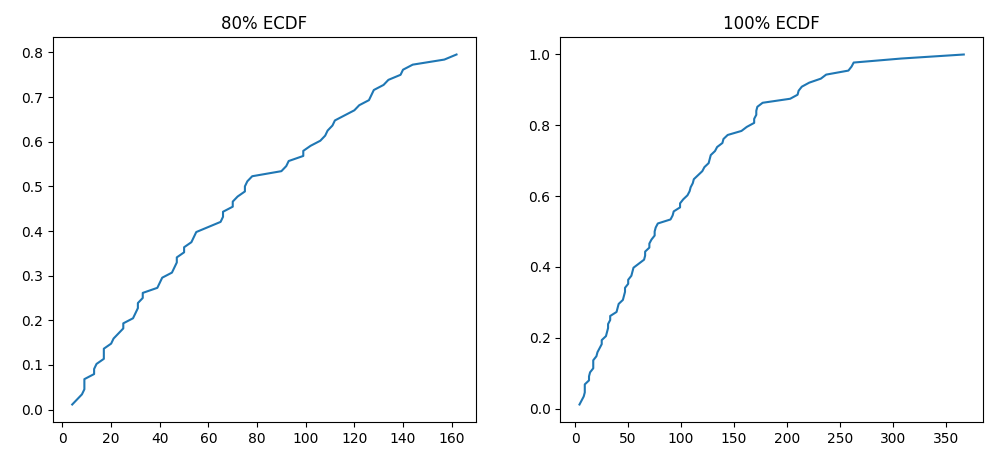

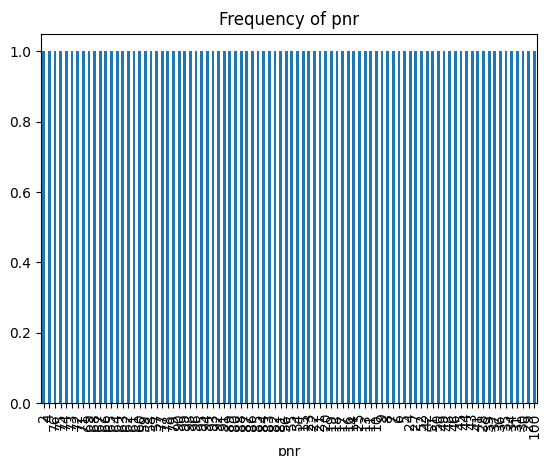

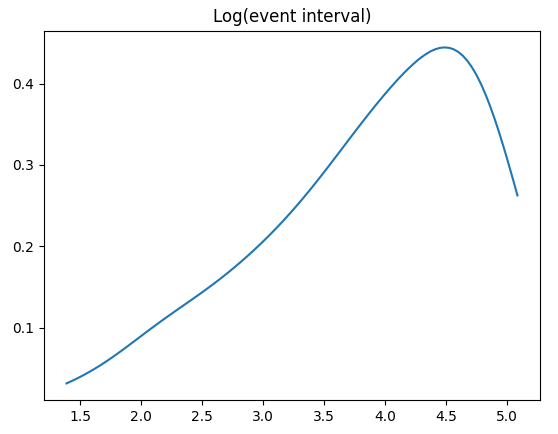

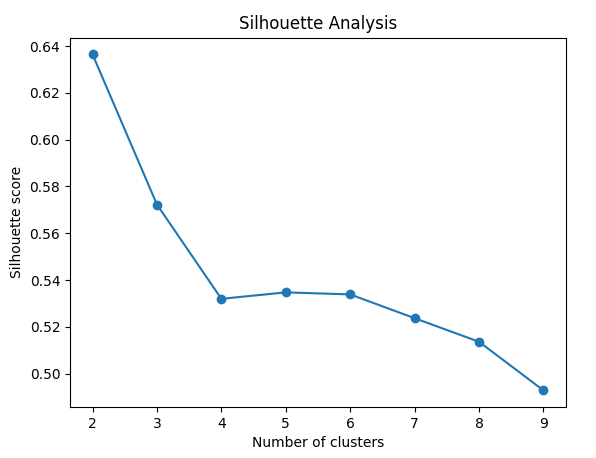

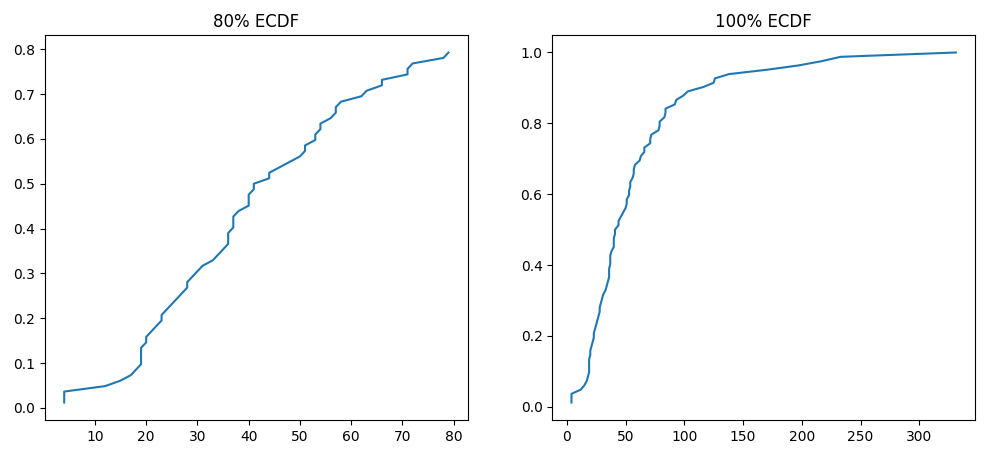

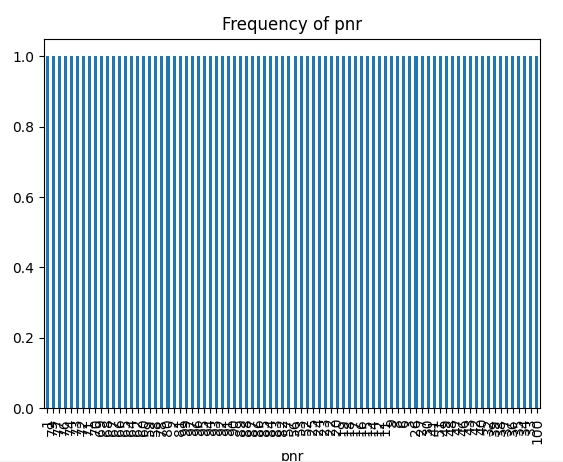

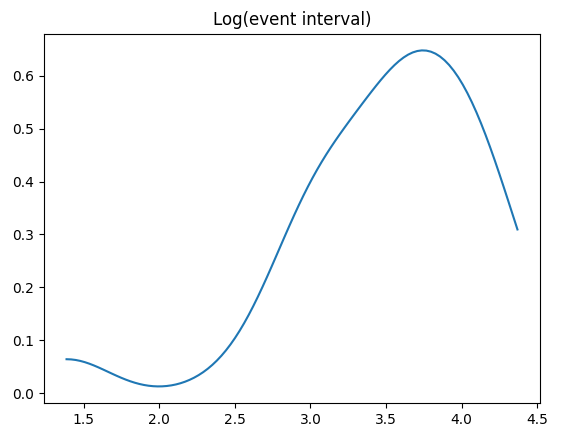

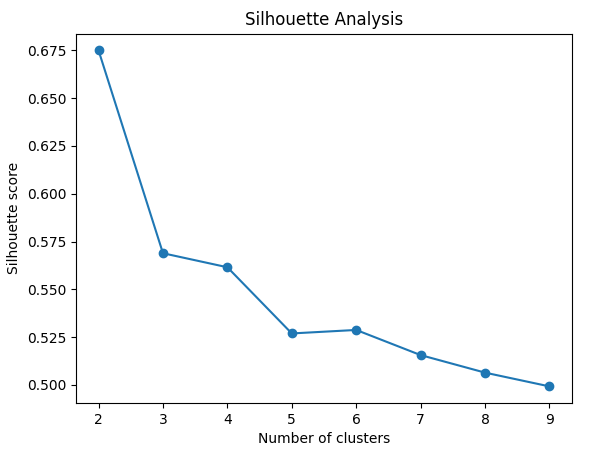

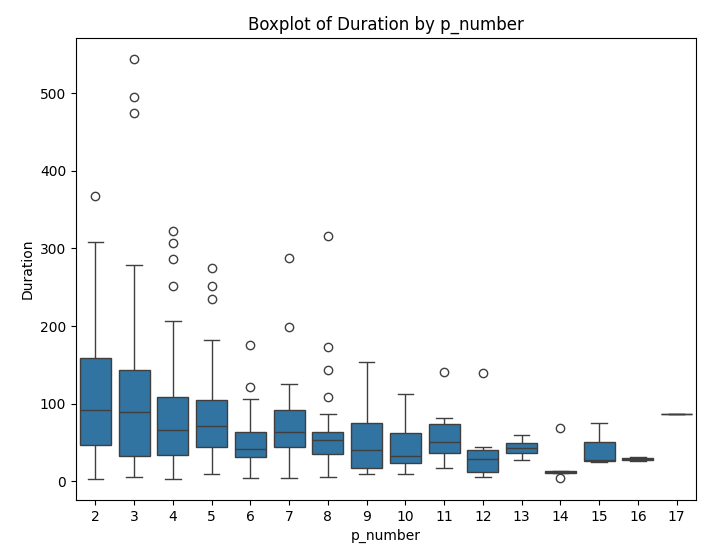

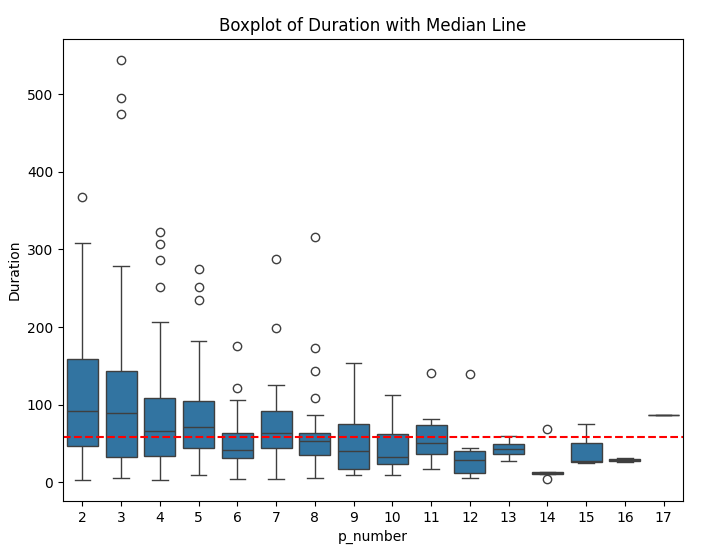

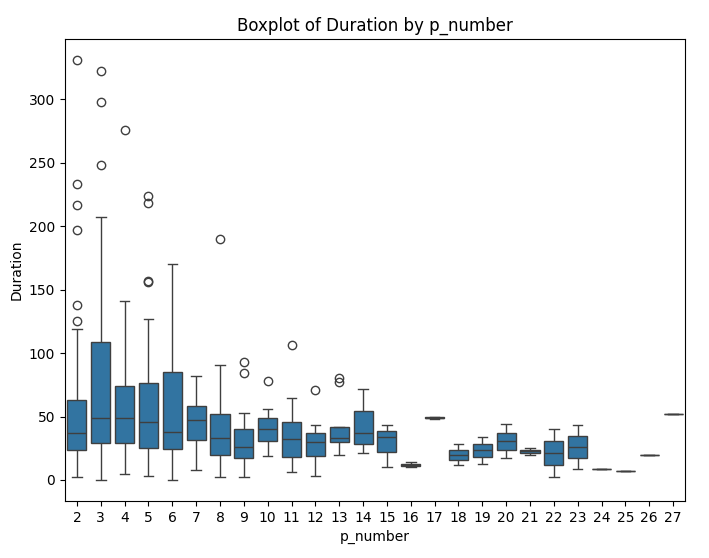

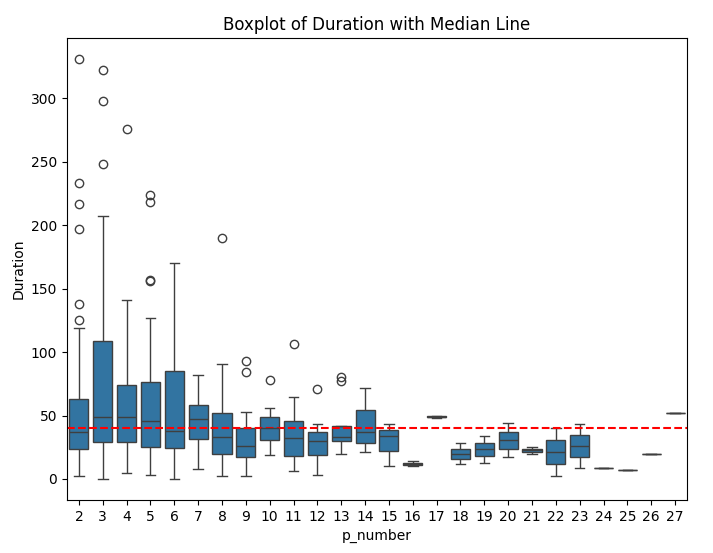